In [1]:
import polars as pl
import numpy as np
from datetime import datetime, timedelta
import json
import os

from data.cons_data import get_cons
from data.market_data import market_data

from utils.market_time import market_hours
from utils.params import PARAMS
from utils.clustering_methods import Clustering_methods

from pairs_finding.pairs_identification import cointegration_pairs
from pairs_finding.clustering import Clustering

from trade.pairs_trader import PairsTrader
from trade.optimizer import optimizer

import warnings

warnings.filterwarnings("ignore")

In [2]:
etf = "QQQ"
cons = get_cons(etf=etf)
cons_date = cons.read()

data = market_data(
    file_path="C:/Users/edmun/OneDrive/Desktop/Quantitative Trading Strategies/Project/qts/data/polygon/*.parquet"
)
out_path = "output/polygon"
earliest_date_year = [
    i
    for i in cons_date.keys()
    if datetime.strptime(i, "%Y-%m-%d").date()
    >= datetime.strptime("2020-06-30", "%Y-%m-%d").date()
]

periods = 10

period_ends = (
    pl.DataFrame(earliest_date_year, schema=["Date"])
    .with_columns(
        pl.all().cast(pl.Date),
    )
    .with_columns((pl.col("Date").rank() // periods).alias("Chunk"))
    .group_by("Chunk", maintain_order=True)
    .agg(pl.col("Date").last())["Date"]
    .dt.strftime("%Y-%m-%d")
    .to_list()
)

In [3]:
pairs = [("ZM", "SBUX")]

In [4]:
data.read(["ZM", "SBUX"], start="2021-06-30", end="2021-12-31")

True

In [5]:
trade_this = data.filter(resample_freq="1m", hours=market_hours.MARKET)

In [6]:
params = {
    (p1, p2): {
        PARAMS.beta_win: 60,
        PARAMS.z_win: 60,
        PARAMS.z_entry: 2,
        PARAMS.z_exit: 0.5,
        PARAMS.z_stop_scaler: 1.5,
        PARAMS.trade_freq: "10m",
        PARAMS.stop_loss: None,
    }
    for p1, p2 in pairs
}

In [7]:
trader = PairsTrader(
    data=data,
    pairs=pairs,  # list(params.keys()),  # pairs_to_trade
    params=params,
    trade_hour=market_hours.MARKET,
)


In [8]:
pl_next_day = pl.lit("2021-06-30").str.strptime(pl.Date, "%Y-%m-%d")
pl_trade_end = pl.lit("2021-12-31").str.strptime(pl.Date, "%Y-%m-%d")
returns_nocost = trader.backtest(
    start=pl_next_day,
    end=pl_trade_end,
    cost=0.0000,
    stop_loss=None,
)

returns_cost = trader.backtest(
    start=pl_next_day,
    end=pl_trade_end,
    cost=0.0005,
    stop_loss=None
)

<Axes: >

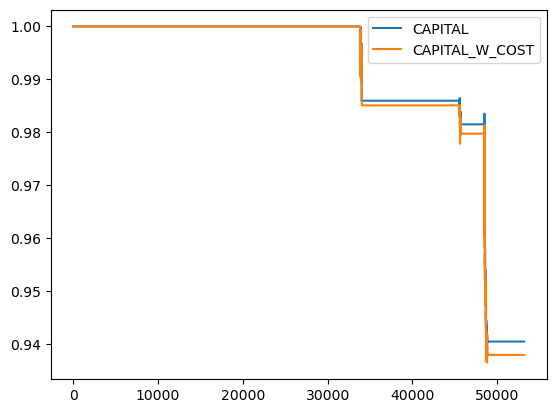

In [9]:
pl.concat([returns_nocost.select('CAPITAL'),(returns_cost.select('CAPITAL').rename({'CAPITAL' : 'CAPITAL_W_COST'}))], how='horizontal').to_pandas().plot()

In [30]:
returns_nocost.select('CAPITAL').with_columns(pl.all().pct_change())

CAPITAL
f64
null
0.0
0.0
0.0
0.0
…
0.0
0.0
0.0


In [32]:
(returns_nocost.select('CAPITAL').with_columns(pl.all().pct_change()).drop_nans().to_numpy().flatten() +1).prod()

0.8246895108729415

# jacob code

In [9]:
import numpy as np
from numpy.lib.stride_tricks import as_strided
from numba import njit


class PairsBacktester:
    @staticmethod
    @njit
    def compute_rolling_zscore(
        price_array: np.ndarray, window_size: int
    ) -> tuple[np.ndarray, np.ndarray]:
        """
        Computes the rolling beta, spread, and z-score for multiple asset pairs over time.

        The input `price_array` is expected to have shape (T, 2 * N), where T is the number
        of time steps and N is the number of pairs. Each pair consists of two columns:
        - Even-indexed columns (0, 2, 4, ...) are treated as the long leg (x)
        - Odd-indexed columns (1, 3, 5, ...) are treated as the short leg (y)

        For each pair, the method:
        1. Computes the rolling beta of y with respect to x
        2. Calculates the spread as `y - beta * x`
        3. Computes the rolling z-score of the spread

        Parameters
        ----------
        price_array : np.ndarray
            2D array of shape (n_timesteps, 2 * n_pairs), where each consecutive pair of
            columns corresponds to (x, y) price data for a trading pair.

        window_size : int
            Rolling window size used to compute the beta, spread, and z-score.

        Returns
        -------
        spread_matrix : np.ndarray
            2D array of shape (n_timesteps, n_pairs) containing the rolling spread series
            for each pair.

        zscore_matrix : np.ndarray
            2D array of shape (n_timesteps, n_pairs) containing the rolling z-scores of
            the spread series for each pair.
        """

        #######################################################################
        #################### STEP 1 : INITIALIZE AND LOOP #####################
        #######################################################################

        n_timesteps = price_array.shape[0]
        n_pairs = price_array.shape[1] // 2
        shape = (
            n_timesteps - window_size + 1,
            window_size,
        )  # get shape to pass to as_strided. can be used for all cus i expect all same size

        beta_matrix = np.full((n_timesteps, n_pairs), np.nan, dtype=np.float64)
        spread_matrix = np.full((n_timesteps, n_pairs), np.nan, dtype=np.float64)
        zscore_matrix = np.full((n_timesteps, n_pairs), np.nan, dtype=np.float64)

        for j in range(n_pairs):
            x = price_array[:, 2 * j]
            y = price_array[:, 2 * j + 1]

            #######################################################################
            #################### STEP 2 : COMPUTE ROLLING BETA ####################
            #######################################################################

            beta = np.full(n_timesteps, np.nan, dtype=np.float64)

            stride = x.strides[0]  # gets number of bytes to go next element
            x_rolling = as_strided(
                x, shape=shape, strides=(stride, stride)
            )  # use x, create shape, then move by stride bytes for each element

            stride = y.strides[0]
            y_rolling = as_strided(y, shape=shape, strides=(stride, stride))

            # compute beta for each timestep
            for i in range(n_timesteps - window_size + 1):
                x_window = x_rolling[i]
                y_window = y_rolling[i]

                x_mean = np.nanmean(x_window)
                y_mean = np.nanmean(y_window)

                cov = np.nanmean((x_window - x_mean) * (y_window - y_mean))
                var = np.nanmean((x_window - x_mean) ** 2)

                # insert computed beta into initialized array
                if var > 0:
                    beta[window_size + i - 1] = cov / var
                else:
                    beta[window_size + i - 1] = beta[
                        window_size + i - 2
                    ]  # forward fill beta

            beta_matrix[:, j] = beta

            #######################################################################
            ################### STEP 3 : COMPUTE ROLLING SPREAD ###################
            #######################################################################

            spread = np.full(n_timesteps, np.nan, dtype=np.float64)

            # start from window_size - 1 since already np.nan intialized
            for i in range(window_size - 1, n_timesteps):
                spread[i] = y[i] - (beta[i] * x[i])

            spread_matrix[:, j] = spread
            #######################################################################
            ################### STEP 4 : COMPUTE ROLLING Z-SCORE ##################
            #######################################################################

            zscore = np.full(n_timesteps, np.nan, dtype=np.float64)

            stride = spread.strides[0]
            spread_rolling = as_strided(spread, shape=shape, strides=(stride, stride))

            for i in range(n_timesteps - window_size + 1):
                spread_window = spread_rolling[i]
                spread_mean = np.nanmean(spread_window)
                spread_std = np.nanstd(spread_window)

                if spread_std > 0:
                    # insert computed zscore into initialized array
                    zscore[i + window_size - 1] = (
                        spread[i + window_size - 1] - spread_mean
                    ) / np.nanstd(spread_window)
                else:
                    zscore[i + window_size - 1] = 0

            zscore_matrix[:, j] = zscore

        return (
            beta_matrix,
            spread_matrix,
            zscore_matrix,
        )  ## [2 * window_size - 3:, :] #weiird slice but trust me its to warm-up the signals

    @staticmethod
    @njit
    def simulate_portfolio(
        price_array: np.ndarray,
        beta_matrix: np.ndarray,
        spread_matrix: np.ndarray,
        zscore_matrix: np.ndarray,
        window_size: int,
        max_positions: int,
        entry_zscore: float,
        take_profit_zscore: float,
        stop_loss_zscore: float,
        reentry_delay: int,
    ) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Simulates a rule-based long-short pairs trading strategy using z-score signals, stop-loss/take-profit rules, and capital allocation constraints.

        This method iterates over time, dynamically assigning positions and rebalancing weights based on pair-specific z-scores and prior portfolio states.
        Capital is allocated to a maximum number of pairs each day, and trade delays are enforced after stop-loss exits.

        Parameters
        ----------
        price_array : np.ndarray
            2D array of shape (n_timesteps, 2 * n_pairs), where each consecutive pair of
            columns corresponds to (x, y) price data for a trading pair.

        beta_matrix : np.ndarray
            2D array of shape (n_timesteps, n_pairs), where each column corresponds beta(x, y) for a trading pair.

        spread_matrix : np.ndarray
            A 2D array of shape (T, N), where T is the number of time steps and N is the number of trading pairs.
            Each column contains the spread values for one pair over time.

        zscore_matrix : np.ndarray
            A 2D array of shape (T, N), corresponding to the z-scores of the spread series for each pair at each time step.

        window_size : int
            The number of periods used to warm up the strategy (e.g., to wait for z-score calculation stability).

        max_positions : int
            Maximum number of simultaneous pair trades allowed in the portfolio at any given time.

        entry_zscore : float
            Z-score threshold used to trigger entry signals. Pairs are entered when the absolute z-score exceeds this threshold.

        take_profit_zscore : float
            Z-score level at which positions are exited for profit. For long spreads, this is triggered when z-score ≥ -take_profit_zscore.
            For short spreads, it is triggered when z-score ≤ take_profit_zscore.

        stop_loss_zscore : float
            Z-score level at which positions are forcefully exited to stop losses. For long spreads, this is triggered when z-score ≤ -stop_loss_zscore.
            For short spreads, it is triggered when z-score ≥ stop_loss_zscore.

        reentry_delay : int
            Number of periods to wait before re-entering a trade after a stop-loss has been triggered for that pair.

        Returns
        -------
        positions_matrix : np.ndarray
            A 2D array of shape (T, N) with values in {1, 0, -1}. Each row represents portfolio positions:
            1 = long spread (buy A, sell B), -1 = short spread (sell A, buy B), 0 = no position.

        weights_matrix : np.ndarray
            A 2D array of shape (T, N + 1). Each row contains portfolio weights:
            the first N elements are weights allocated to pairs, the last element is cash weight.

        returns_matrix : np.ndarray
            A 1D array of shape (T,), representing daily portfolio return at each time step,
            computed as the weighted return of all active positions.
        """

        #######################################################################
        #################### STEP 1 : COMPUTE DAILY RETURNS ###################
        #######################################################################

        n_timesteps = spread_matrix.shape[0]
        n_pairs = spread_matrix.shape[1]

        x_price_matrix = np.empty((n_timesteps, n_pairs), dtype=np.float64)
        y_price_matrix = np.empty((n_timesteps, n_pairs), dtype=np.float64)

        for col in range(n_pairs):
            x_price_matrix[:, col] = price_array[:, 2 * col]
            y_price_matrix[:, col] = price_array[:, 2 * col + 1]

        # spread_rtn_matrix = np.full((n_timesteps, n_pairs), np.nan, dtype = np.float64)

        # compute spread return by using (T spread / T-1 spread)
        # for i in range(window_size, n_timesteps): # window_size because need 2 days to get returns.
        #    spread_rtn_matrix[i, :] = spread_matrix[i, :] / spread_matrix[i - 1, :]

        #######################################################################
        ################### STEP 2 : FIGURE OUT PORTF VAL #####################
        #######################################################################

        allocation = 1 / max_positions

        # initialize for positions, wgts, rtns tracking
        delay_tracker = np.full(
            n_pairs, 0, dtype=int
        )  # to prevent too early re-enter same position
        beta_tracker = np.full(n_pairs, 0.0, dtype=np.float64)  # track entry beta

        returns_matrix = np.full(
            n_timesteps, np.nan, dtype=np.float64
        )  # storage matrix of returns
        positions_matrix = np.full(
            (n_timesteps, n_pairs), 0, dtype=int
        )  # storage matrix of positions
        weights_matrix = np.full(
            (n_timesteps, n_pairs + 1), 0.0, dtype=np.float64
        )  # +1 col for cash
        weights_matrix[:, -1] = 1  # for cash => 100% in cash

        for i in range(window_size, n_timesteps):  # FOR EACH NEW FUCKING TIME STEP
            #########################################################################
            ################ STEP 2.1 : INITIALIZATION & PREPERATION ################
            #########################################################################

            tm1_weights = weights_matrix[i - 1, :]  # get prev weights
            tm1_positions = positions_matrix[i - 1, :]  # get prev positions

            t_weights = tm1_weights.copy()  # get t weights. just copy first
            t_positions = (
                tm1_positions.copy()
            )  # initialize array for T positions. use t-1 as template

            tm1_beta = beta_matrix[i - 1, :]
            tm1_zscore = zscore_matrix[i - 1, :]

            tm1_x_price = x_price_matrix[i - 1, :]
            tm1_y_price = y_price_matrix[i - 1, :]

            t_x_price = x_price_matrix[i, :]
            t_y_price = y_price_matrix[i, :]

            # CHECK TP/SL TO GET CLEARER PICTURE
            for j in range(n_pairs):  # for each pair,
                if tm1_positions[j] == 1:  # if long position, check tp/sl
                    if (
                        tm1_zscore[j] >= -take_profit_zscore
                    ):  # if COULD HAVE take profit
                        t_positions[j] = 0  # take profit!
                        t_weights[-1] += tm1_weights[
                            j
                        ]  # assume sell at prev close, add back to cash

                        t_weights[j] = 0.0  # clear out position
                        beta_tracker[j] = 0.0  # clear beta cache

                    elif tm1_zscore[j] <= -stop_loss_zscore:  # if reach stop loss!
                        t_positions[j] = 0  # stop loss
                        t_weights[-1] += tm1_weights[
                            j
                        ]  # assume sell at prev close, add back to cash

                        t_weights[j] = 0.0  # clear out position
                        beta_tracker[j] = 0.0  # clear beta cache
                        delay_tracker[j] = (
                            reentry_delay  # CANNOT BUY INSTANTLY NEXT PERIOD
                        )

                elif tm1_positions[j] == -1:  # if short position, check tp/sl
                    if (
                        tm1_zscore[j] <= take_profit_zscore
                    ):  # if could have taken profit
                        t_positions[j] = 0  # take profit!
                        t_weights[-1] += tm1_weights[
                            j
                        ]  # assume sell at prev close, add back to cash

                        t_weights[j] = 0.0  # clear out position
                        beta_tracker[j] = 0.0  # clear beta cache

                    elif (
                        tm1_zscore[j] >= stop_loss_zscore
                    ):  # if reach stop loss ALREADY DIE LAST PERIOD
                        t_positions[j] = 0  # stop loss
                        t_weights[-1] += tm1_weights[
                            j
                        ]  # assume sell at prev close, add back to cash

                        t_weights[j] = 0.0  # clear out position
                        beta_tracker[j] = 0.0  # clear beta cache
                        delay_tracker[j] = (
                            reentry_delay  # CANNOT BUY INSTANTLY NEXT PERIOD
                        )

            # get number of currently open positions, after checking SL/TP but BEFORE new entry in current timestep
            # n_open_positions = np.sum(np.abs(positions_matrix[i - 1, :]) > 0)
            n_open_positions = np.sum(np.abs(t_positions))

            # get number of eligible pairs for current timestep
            temp_array = np.full(
                n_pairs, 0, dtype=int
            )  # temp variable to count new positions

            for k in range(n_pairs):  # ignore all pairs that recently exited
                if (
                    tm1_positions[k] == 0
                    and np.abs(tm1_zscore[k]) >= entry_zscore
                    and delay_tracker[k] == 0
                ):
                    temp_array[k] = 1

            n_new_positions = np.sum(temp_array)

            #########################################################################
            ##################### STEP 2.2 : MANAGING POSITIONS #####################
            #########################################################################

            # NOTHING TO BUY / SELL
            if n_new_positions == 0:
                pass

            elif n_open_positions >= max_positions:  # if too many positions, dont enter
                pass  # just proceed to float weights

            # WANT TO TRADE BUT CONSTRAINED
            elif (
                n_new_positions + n_open_positions
            ) > max_positions:  # if EXCEED max limit of open positions
                # gotta rank by zscore cus i aint got no money
                max_new_positions = (
                    max_positions - n_open_positions
                )  # HOW MANY CAN WE BUY ACTUALLY

                temp_array = np.abs(tm1_zscore)  # temp variable to rank zscores
                for m in range(n_pairs):  # ignore all pairs that recently exited
                    if delay_tracker[m] != 0:
                        temp_array[m] = 0
                    if t_positions[m] != 0:
                        temp_array[m] = 0

                sorted_indices = np.argsort(temp_array)[
                    -max_new_positions:
                ]  # get the index of highest zscores
                sorted_indices = sorted_indices[
                    ::-1
                ]  # reverse the array. before it was weakest zscore to strongest zscore

                # prepare to buy/sell motherfucker
                for a in sorted_indices:  # we're restricted. only buy best zscores
                    if (
                        tm1_positions[a] == 0 and tm1_zscore[a] >= entry_zscore
                    ):  # if no active posn + short signal cus spread too wide. dont check delay cus done in temp_array
                        t_positions[a] = -1  # short the spread
                        t_weights[a] = (
                            allocation if allocation <= t_weights[-1] else t_weights[-1]
                        )
                        t_weights[-1] -= t_weights[a]  # remove weight from cash
                        beta_tracker[a] = tm1_beta[a]  # track entry beta

                    elif (
                        tm1_positions[a] == 0 and tm1_zscore[a] <= -entry_zscore
                    ):  # if no active posn + long signal cus spread too narrow
                        t_positions[a] = 1  # long the spread
                        t_weights[a] = (
                            allocation if allocation <= t_weights[-1] else t_weights[-1]
                        )
                        t_weights[-1] -= t_weights[a]  # remove weight from cash
                        beta_tracker[a] = tm1_beta[a]  # track entry beta

            # YOLO TRADE LETS GO
            else:  # means (n_new_positions + n_open_positions) <= max_positions. nothing breaking. within limits
                # prepare to buy/sell motherfucker
                for b in range(n_pairs):  # for each pair,
                    if (
                        tm1_positions[b] == 0
                        and tm1_zscore[b] >= entry_zscore
                        and delay_tracker[b] == 0
                    ):  # if no active posn + short signal + not recent sl cus spread too wide
                        t_positions[b] = -1  # short the spread
                        t_weights[b] = (
                            allocation if allocation <= t_weights[-1] else t_weights[-1]
                        )  # ENTER
                        t_weights[-1] -= t_weights[b]  # DEDUCT CASH
                        beta_tracker[b] = tm1_beta[b]  # track entry beta

                    elif (
                        tm1_positions[b] == 0
                        and tm1_zscore[b] <= -entry_zscore
                        and delay_tracker[b] == 0
                    ):  # if no active posn + long signal + not recent slcus spread too narrow
                        t_positions[b] = 1  # long the spread
                        t_weights[b] = (
                            allocation if allocation <= t_weights[-1] else t_weights[-1]
                        )  # ENTER
                        t_weights[-1] -= t_weights[b]  # DEDUCT CASH
                        beta_tracker[b] = tm1_beta[b]  # track entry beta

            #########################################################################
            #################### STEP 2.3 : COMPUTE WGTS & RTNS #####################
            #########################################################################

            tm1_spread_price = tm1_y_price - (beta_tracker * tm1_x_price)
            t_spread_price = t_y_price - (beta_tracker * t_x_price)
            net_spread_price = tm1_y_price + np.abs(beta_tracker * tm1_x_price)

            returns_array = t_positions * (
                (t_spread_price - tm1_spread_price) / net_spread_price
            )
            daily_returns = np.sum(
                returns_array * t_weights[:-1]
            )  # compute t_weights before float!!

            # np.sum((spread_rtn_matrix[i, :] - 1) * t_weights[:-1]) # compute t_weights before float!!

            t_weights[:-1] = (returns_array + 1) * t_weights[
                :-1
            ]  # float weights of pairs only! fuck cash

            t_weights = np.round(t_weights, 6)
            total = np.sum(t_weights)
            t_weights /= total

            #########################################################################
            #################### STEP 2.4 : APPEND TO MAIN MATRIX ###################
            #########################################################################
            # decrease delay_tracker

            for d in range(n_pairs):
                if delay_tracker[d] > 0:
                    delay_tracker[d] -= 1

            positions_matrix[i, :] = t_positions
            weights_matrix[i, :] = t_weights
            returns_matrix[i] = daily_returns

        return positions_matrix, weights_matrix, returns_matrix


In [10]:
max_positions = 4
entry_zscore = 2.0
take_profit_zscore = 0.5
stop_loss_zscore = 3
reentry_delay = 30
window_size = 60
# price_array = pl.read_parquet()
price_array = trader.generate_backtest_df().select(
    "PRICE_SBUX_ZM_ON_SBUX", "PRICE_ZM_ZM_ON_SBUX"
)
price_array = price_array.to_numpy()

In [11]:
beta_matrix, spread_matrix, zscore_matrix = PairsBacktester.compute_rolling_zscore(
    price_array, window_size=window_size
)
positions_matrix, weights_matrix, returns_matrix = PairsBacktester.simulate_portfolio(
    price_array,
    beta_matrix,
    spread_matrix,
    zscore_matrix,
    window_size,
    max_positions=2,
    entry_zscore=2.0,
    take_profit_zscore=0.5,
    stop_loss_zscore=3,
    reentry_delay=60,
)

In [12]:
pl.concat(
    [
        returns,
        pl.DataFrame(beta_matrix, schema=["J_beta"]),
        pl.DataFrame(spread_matrix, schema=["J_spread_matrix"]),
        pl.DataFrame(zscore_matrix, schema=["J_zscore_matrix"]),
        pl.DataFrame(positions_matrix, schema=["J_positions_matrix"]),
        pl.DataFrame(weights_matrix, schema=["J_weights_matrix1",'cash']),
        pl.DataFrame(returns_matrix, schema=["J_returns_matrix"]),
    ],
    how="horizontal",
).write_excel('debuggggg.xlsx')

In [21]:
pl.concat([
    (pl.DataFrame(returns_matrix, schema=["J_returns_matrix"]).fill_nan(0)+1).with_columns(pl.all().cum_prod()),
    returns.select('CAPITAL')
], how='horizontal')



J_returns_matrix,CAPITAL
f64,f64
1.0,1.0
1.0,1.0
1.0,1.0
1.0,1.0
1.0,1.0
…,…
0.935002,0.842714
0.935002,0.842719
0.935002,0.843013
